In [12]:
!pip install meteostat


[notice] A new release of pip is available: 25.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import holidays # For working with holiday data
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from datetime import datetime
from meteostat import Stations, Daily # For working with weather data
from xgboost import plot_importance

In [14]:
## Features Functions

def create_datetime_features(df):
    """
    Creates time series features from datetime index
    Adapted from: https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost#Look-at-Worst-and-Best-Predicted-Days
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date'] = pd.to_datetime(df.index.date)
    return df

def get_holiday_features(df, country_code='US'):
    """
    Creates holiday features from datetime index
    """
    year_range = list(range(min(df.index.year), max(df.index.year) + 1))
    country_holidays = holidays.country_holidays(
        country_code,
        years=year_range,
        observed=False
    )
    holiday_df = pd.DataFrame(country_holidays.items())
    holiday_df.columns = ['date', 'holiday']
    holiday_df['date'] = pd.to_datetime(holiday_df['date'])
    return holiday_df

def get_weather_features(df, lat, lon):
    """
    Creates weather features based on latitude and longitude
    """
    room_temperature = 20  # Weather data is in Celsius
    start = min(df.index)
    end = max(df.index)

    stations = Stations()
    stations = stations.nearby(lat, lon)
    station = stations.fetch(1)

    # Get daily data
    weather_data = Daily(station['wmo'][0], start, end)
    weather_data = weather_data.fetch()
    weather_data = weather_data.dropna(axis=1)
    weather_data = weather_data.reset_index()
    weather_data['tmin_abs_diff_from_room_temperature'] = abs(weather_data['tmin'] - room_temperature)
    weather_data['tmax_abs_diff_from_room_temperature'] = abs(weather_data['tmax'] - room_temperature)
    weather_data = weather_data.rename(columns ={'time': 'date'})

    return weather_data 

In [15]:
df = pd.read_csv('PJME_hourly.csv', index_col=[0], parse_dates=[0])

In [16]:
data = create_datetime_features(df)
holiday_features = get_holiday_features(data)
weather_features = get_weather_features(data, 39.8719, -75.2411) #Philadelphia, PA (PHL Airport)

In [17]:
data['datetime'] = data.index

In [18]:
data = data.merge(holiday_features, how='left', on='date')
data['holiday'] = data['holiday'].fillna('')
data = pd.get_dummies(data)
data = data.merge(weather_features, how='left', on='date')

Calculating correlation for: ['PJME_MW', 'tmin', 'tmax', 'prcp', 'wspd', 'tmin_abs_diff_from_room_temperature', 'tmax_abs_diff_from_room_temperature']


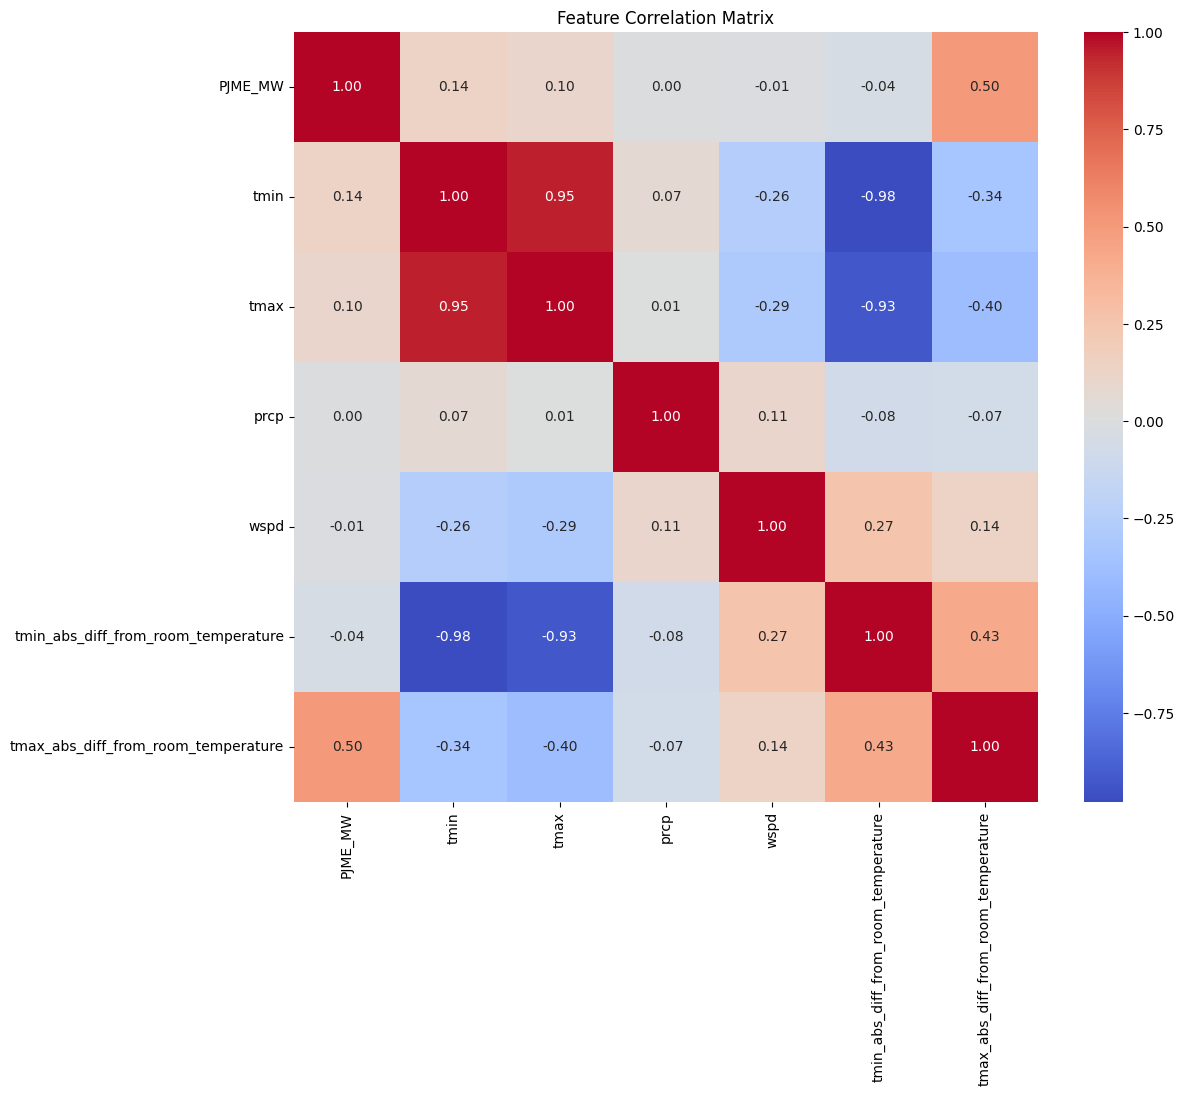

In [23]:
# 1. Define the columns you WANT to check
desired_columns = [
    'load', 'PJME_MW',          # Target (check which one you have)
    'tmin', 'tmax',          # Temperature
    'prcp', 'snow', 'wspd',  # Other weather
    'tmin_abs_diff_from_room_temperature',
    'tmax_abs_diff_from_room_temperature'
]

# 2. Filter the list to keep only columns that ARE in your dataframe
# This automatically removes 'snow', 'PJME', or anything else missing
available_columns = [col for col in desired_columns if col in data.columns]

print(f"Calculating correlation for: {available_columns}")

# 3. Run correlation on the safe list
correlation_matrix = data[available_columns].corr()

# 4. Plot
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

In [24]:
split_date = datetime(2015, 1, 1)
train = data.loc[data['datetime'] <= split_date].copy()
test = data.loc[data['datetime'] > split_date].copy()
train_drop_cols = ['date', 'datetime', 'PJME_MW']
X_train = train.drop(columns=train_drop_cols)
y_train = train['PJME_MW']
X_test = test.drop(columns=train_drop_cols)
y_test = test['PJME_MW']

In [25]:
reg = xgb.XGBRegressor(
    n_estimators=1000,
    early_stopping_rounds=50
)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

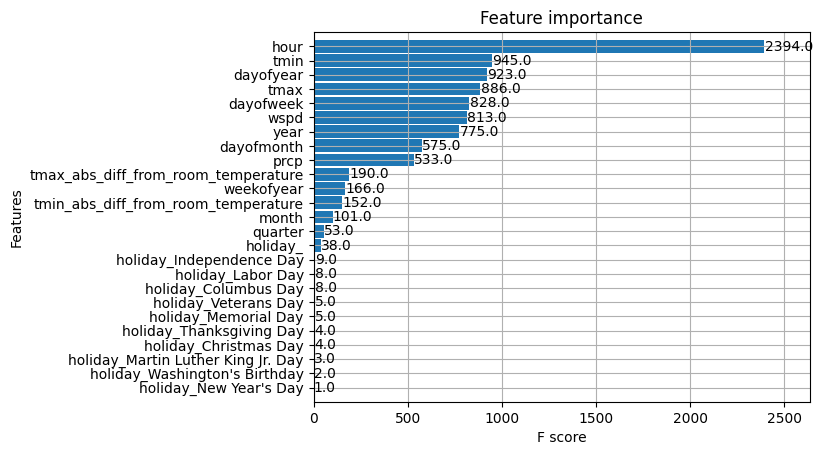

In [26]:
_ = plot_importance(reg, height=0.9)

In [27]:
predictions = reg.predict(X_test)

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

Mean Absolute Error: 1214.984463961958
Mean Squared Error: 2437570.976447448


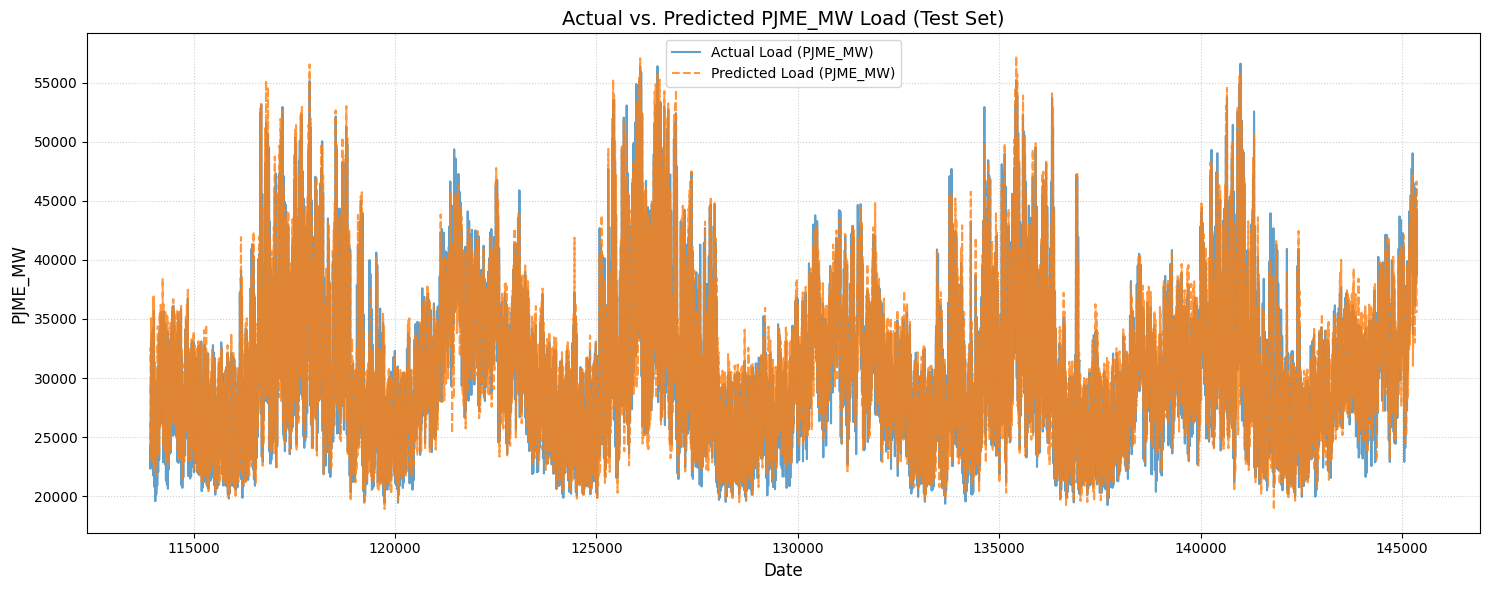

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

plot_df = pd.DataFrame({
    'Actual Load': y_test,
    'Predictions': predictions
}, index=y_test.index)

# 2. Plot the results
plt.figure(figsize=(15, 6))

# Plot Actual Load
plt.plot(plot_df.index, plot_df['Actual Load'], 
         label='Actual Load (PJME_MW)', 
         alpha=0.7)

# Plot Predicted Load
plt.plot(plot_df.index, plot_df['Predictions'], 
         label='Predicted Load (PJME_MW)', 
         alpha=0.8, 
         linestyle='--')

plt.title('Actual vs. Predicted PJME_MW Load (Test Set)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('PJME_MW', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()